# Estimating grid orientation and grid spacing

This notebook deals with finding the best grid parameter for the transformation from x,y to v0,v1,v2 coordinates.

This involves the following steps.

    1.Getting our best estimates of the parameters from traditional grid cell methods (orientation and spacing from spatial autocorrelation, offset from firing rate map).
    2.Starting from the parameters of step 1, fitting the activity of the grid cell with a model of a perfect grid cell to find better parameters.
    3.Starting from the parameters of step 2, fitting the activity of the grid cell with a more flexible model that allows deviation from the perfect grid pattern.

The parameters from steps 2 and 3 are saved in a file for later use.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import multivariate_normal
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from scipy.stats import wilcoxon, pearsonr
from scipy.signal import find_peaks
import torch
import numpy as np

from functions import *

To test the estimation of grid orientation and grid spacing, we can first simulate a group of grid cells as shown in the first notebook "1_Simulating grid cell spike trains.ipynb"

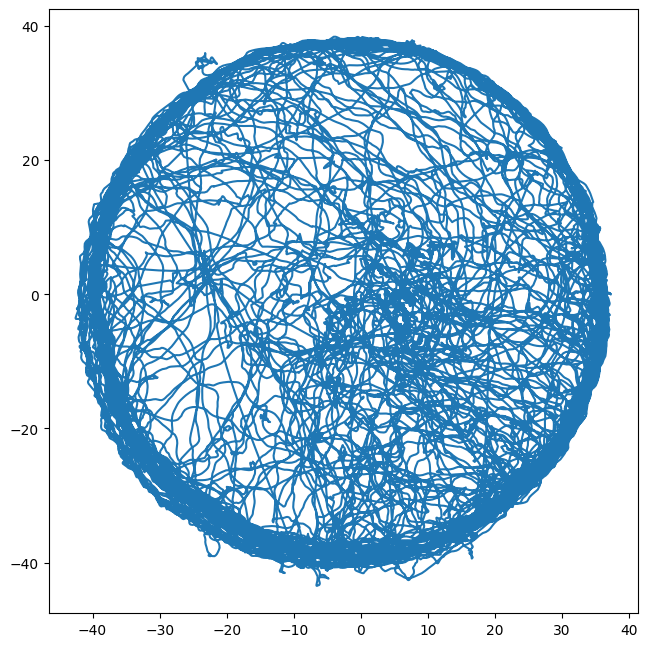

In [3]:
ap = Animal_pose()
ap.load_pose_from_file(file_name=lastRF)


fig, ax = plt.subplots(figsize=(8,8))

ax.plot(ap.pose[:,1],ap.pose[:,2])
ax.set_aspect('equal')  

In [4]:
grid_param = {}
grid_param["n_cells"] = 20
grid_param["orientation"] = np.array([0,np.pi/3,np.pi/3*2])
grid_spacing = 35
grid_param["period"] = np.array([grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6)])
grid_param["offset"] = np.random.rand(grid_param["n_cells"],2)*grid_param["period"][0]
peak_rates = np.random.normal(loc=15.0, scale=10.0, size=grid_param["n_cells"] )
peak_rates[peak_rates<5] = 5
grid_param["peak_rate"] = peak_rates

In [5]:
neuron_list = [Simulated_grid_cell(name=f"{i}", 
                                   offset=grid_param["offset"][i,:],
                                   orientation=grid_param["orientation"],
                                   period=grid_param["period"], 
                                   peak_rate=grid_param["peak_rate"][i], ap=ap)  for i in tqdm(range(grid_param["n_cells"]))]


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


In [6]:
for n in neuron_list:
    n.spatial_properties.firing_rate_map_2d()

In [7]:
ori_inter = n.ap.intervals.inter

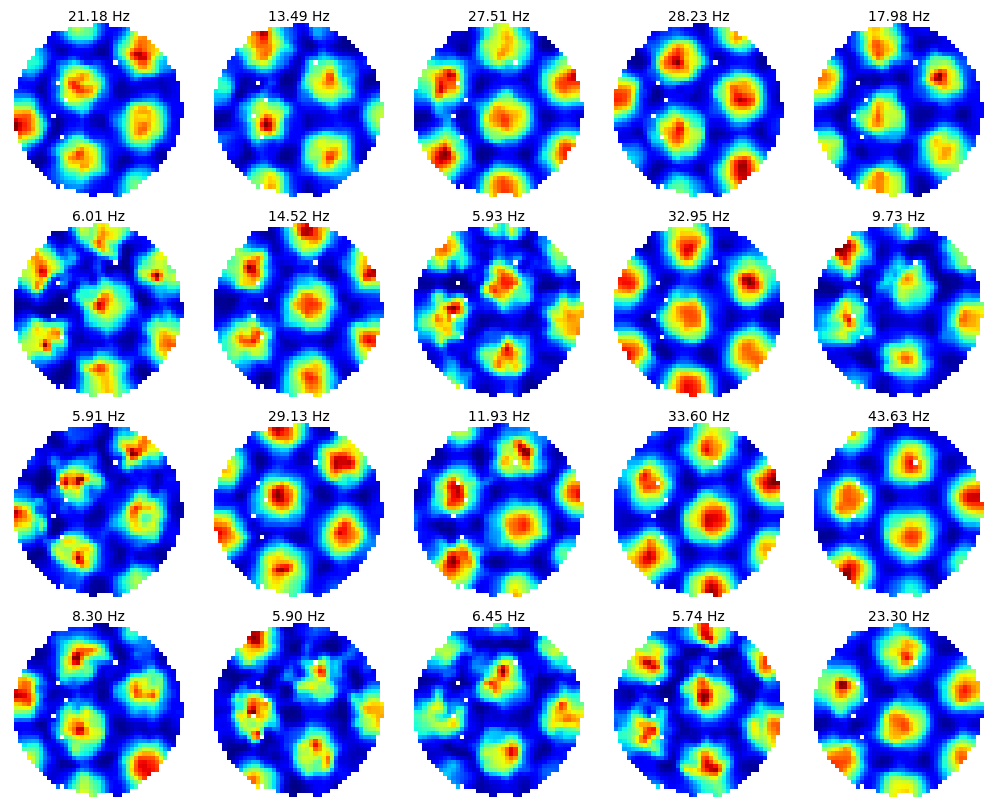

In [8]:
rowSize,colSize= 2,2
ncols=5
nrows=int(np.ceil(len(neuron_list)/ncols))
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(neuron_list):
    x = int(i/ncols)
    y = i%ncols
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))



# Find the best match for orientation and spacing

Our parameters are

    Orientation of 3 grid axes
    Period of 3 grid axes
    Phase of the neuron on the 3 grid axes
    Peak firing rate of the neuron

Getting the best parameters will ensure that we find the best transformation of path x,y coordinate into grid cell representation coordinates.

For this transformation, we need the orientation of the 3 axes and the period along the 3 axes.

We use a grid cell model with the above parameter to predict the firing rate of the cell from the animal position. We find the best parameters using gradient descent.

Setting the initial values of the parameter to the best possible guess is important to avoid the many local minima possible when fitting the grid cell model. If we start with values that are not too far off from the solution, the model usually converges to parameters that will generate a firing rate map that is highly correlated with the original firing rate map (r > 0.9).

We don't model the difference in rate between the different fields of the grid.

In [12]:
def find_grid_cell_parameters(neuron_list):
    cm_per_bin = 3
    xy_range=np.array([[-50,-90],[50,60]])
    

    # Calculate firing rate maps and spatial autocorrelation to have a reasonable estimate of the grid parameters
    for n in neuron_list:
        n.spatial_properties.firing_rate_map_2d(cm_per_bin =cm_per_bin, smoothing_sigma_cm = 5, smoothing=True,xy_range=xy_range)
        n.spatial_properties.spatial_autocorrelation_map_2d(min_n_for_correlation=50,invalid_to_nan=True)
        n.spatial_properties.grid_score()
        n.spike_train.instantaneous_firing_rate(bin_size_sec = 0.02,sigma=1,outside_interval_solution="remove")
    
    # our rough estimate of spacing, orientation and offset, used as a starting point
    gcSpacing = [n.spatial_properties.grid_info()[0] for n in neuron_list]
    gcOrientation = [n.spatial_properties.grid_info()[1] for n in neuron_list]
    gcPeakLocation = [n.spatial_properties.firing_rate_map_peak_location() for n in neuron_list]
    
    # show the firing rate maps
    print("Firing rate maps used to find grid cell parameters")
    rowSize,colSize= 1.6,1.6
    ncols=6
    nrows=int(np.ceil(len(neuron_list)/ncols))
    fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
    mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)
    for i,n in enumerate(neuron_list):
        c= int(i % ncols)
        r= int(i / ncols)
        ax = fig.add_subplot(mainSpec[r,c])
        plotMap(ax,n.spatial_properties.firing_rate_map,title="{} - {:.2f} Hz".format(n.name,np.nanmax(n.spatial_properties.firing_rate_map)),titleY=0.95,titleFontSize=9,transpose=True,cmap="jet",vmin=0)
        xy,grid_peak_location =  gcPeakLocation[i]
        ax.scatter(xy[0],xy[1],color="black", s = 35)
        ax.scatter(xy[0],xy[1],color="red", s = 10)
    
    # plot the distribution of spacing
    rowSize,colSize= 1.8,1.8
    ncols=1
    nrows=1
    fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
    mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)

    ax = fig.add_subplot(mainSpec[0])
    ax.hist(gcSpacing)
    ax.set_xlim(30,50)
    ax.set_xlabel("Grid spacing (cm)")
    ax.set_ylabel("Neurons")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    

    # do the model fitting, the function is in the file function of the path_reconstruction directory
    res = [fit_grid_parameter_from_grid_cell_activity(n,n.ap,n.ap) for n in tqdm(neuron_list)]
    
    #save the results into a file for quick access
    fn = "../data/grid_cell_parameters.pkl"
    print("Saving:",fn)
    with open(fn, 'wb') as handle:
        pickle.dump(res, handle)
    
    
    return res

In [13]:
for n in neuron_list:
    n.ap.set_intervals(ori_inter)
    n.spike_train.set_intervals(ori_inter)

Firing rate maps used to find grid cell parameters


  0%|          | 0/1 [00:00<?, ?it/s]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-44,  -9]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


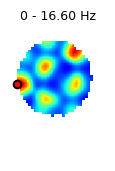

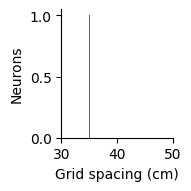

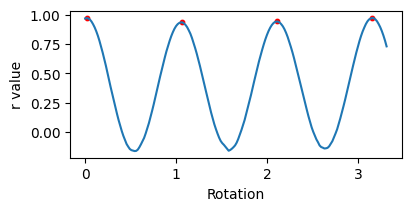

Visualize real and simulated grid pattern before fitting


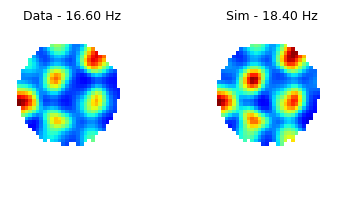

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 75.93861
Improvement of firing rate maps correlation after rigid fitting: from 0.903 to 0.953
Fitting more flexible grid cell model
Loss after flexible model fitting: 75.92113
Improvement of firing rate maps correlation after flexible fitting: from 0.953 to 0.939
Comparison of firing rate maps after fitting different models


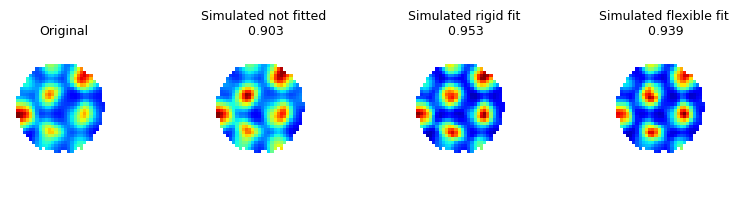

100%|██████████| 1/1 [01:15<00:00, 75.43s/it]

Saving: ../data/grid_cell_parameters.pkl


[{'name': '0',
  'grid_param_initial': {'period': array([30.3509004, 30.3509004, 30.3509004]),
   'offset': array([-44,  -9]),
   'peak_rate': 25,
   'orientation': array([0.01754282, 1.07011191, 2.10513819])},
  'grid_param_model_rigid': {'period': array([30.388979, 30.388979, 30.388979], dtype=float32),
   'offset': array([-41.321434,  -8.780185], dtype=float32),
   'peak_rate': array([19.9434], dtype=float32),
   'orientation': array([0.00552261, 1.05272016, 2.09991771])},
  'loss_rigid': array(75.93861, dtype=float32),
  'r_rigid': 0.9533985239130301,
  'grid_param_model_flexible': {'period': array([30.179018, 30.320965, 30.464663], dtype=float32),
   'offset': array([-41.06191 ,  -8.597529], dtype=float32),
   'peak_rate': array([19.954393], dtype=float32),
   'orientation': array([0.00973757, 1.0460675 , 2.0994031 ], dtype=float32)},
  'loss_flexible': array(75.92113, dtype=float32),
  'r_flexible': 0.9394284266366763}]

In [14]:
find_grid_cell_parameters(neuron_list[:1])

# Find the grid cell parameters for all cells

In [15]:
find_grid_cell_parameters(neuron_list)

Firing rate maps used to find grid cell parameters


  0%|          | 0/20 [00:00<?, ?it/s]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-44,  -9]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
